<a href="https://colab.research.google.com/github/Soham-Gaonkar/STTAI-Assignment11-QuantizationTechniques/blob/main/STT_QuantizationTechniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Model Quantization Techniques
 The objective is to explore model quantization techniques, including dynamic quantization and half-precision quantization.

## Dataset Preparation
Load the training and test datasets. Split 20% of the training dataset as the validation set.

In [1]:
import os
import requests

os.makedirs("data", exist_ok=True)

datasets = {
    "train.tsv": "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv",
    "test.tsv": "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv",
}

def download_file(filename, url):
    filepath = os.path.join("data", filename)
    if not os.path.exists(filepath):
        response = requests.get(url)
        response.raise_for_status()
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(response.text)
        print(f"{filename} downloaded.")
    else:
        print(f"{filename} already exists.")

for filename, url in datasets.items():
    download_file(filename, url)

train.tsv downloaded.
test.tsv downloaded.


In [2]:
import pandas as pd

train_data_df = pd.read_csv('data/train.tsv', sep='\t', header=None, names=['text','label'])
train_data_df['label'] = train_data_df['label'].astype(int)
display(train_data_df.head())
# 0 is negative, 1 is positive

test_data_df = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['text','label'])
test_data_df['label'] = test_data_df['label'].astype(int)
display(test_data_df.head())

,text,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


,text,label
0,"no movement , no yuks , not much of anything",0
1,"a gob of drivel so sickly sweet , even the eag...",0
2,"gangs of new york is an unapologetic mess , wh...",0
3,"we never really feel involved with the story ,...",0
4,this is one of polanski 's best films,1


In [3]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_data_df, test_size=0.2, random_state=42)
print(train_df.shape, val_df.shape)

print(train_df.info())
print(val_df.info())
print(test_data_df.info())

train_df.to_csv("data/train_df.tsv", sep="\t", index=False)
val_df.to_csv("data/val_df.tsv", sep="\t", index=False)
test_data_df.to_csv("data/test_df.tsv", sep="\t", index=False)
print("train_df, val_df, and test_df saved")


# Display exact memory usage of the DataFrames in terms of bytes
print("Memory usage of train_df:", train_df.memory_usage(deep=True).sum(), "bytes")
print("Memory usage of val_df:", val_df.memory_usage(deep=True).sum(), "bytes")
print("Memory usage of test_df:", test_data_df.memory_usage(deep=True).sum(), "bytes")

(5536, 2) (1384, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 5536 entries, 4457 to 860
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5536 non-null   object
 1   label   5536 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 129.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1384 entries, 468 to 5154
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1384 non-null   object
 1   label   1384 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1821 non-null   object
 1   label   1821 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.6+ KB
None
train_df, val_df, and test_df saved
Memory usage of train_df: 91869

## Construct Multi-Layer Perceptron (MLP) Model
Define an MLP model with `hidden_sizes=[512, 256, 128, 64]` and two output labels. Count the number of trainable parameters using an automated function.

In [4]:
import os

models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir, exist_ok=True)
print(f"Models directory created at: {models_dir}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# load data data/imdb.csv
train_df = pd.read_csv('data/train_df.tsv', sep='\t')
test_df = pd.read_csv('data/test_df.tsv', sep='\t', header=None, names=['text', 'label'])
val_df = pd.read_csv('data/val_df.tsv', sep='\t')

# test_df.head()
train_df.head()

Models directory created at: models


,text,label
0,graphic sex may be what 's attracting audience...,1
1,perhaps the grossest movie ever made,0
2,"the film is moody , oozing , chilling and hear...",1
3,watching the chemistry between freeman and jud...,1
4,the wonderfully lush morvern callar is pure pu...,1


In [5]:
# remove first row
test_df = test_df.iloc[1:].copy()
# convert label to integer
test_df['label'] = test_df['label'].astype(int)
display(test_df.head())

,text,label
1,"no movement , no yuks , not much of anything",0
2,"a gob of drivel so sickly sweet , even the eag...",0
3,"gangs of new york is an unapologetic mess , wh...",0
4,"we never really feel involved with the story ,...",0
5,this is one of polanski 's best films,1


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_prob=0.3):
        super(SentimentClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[3], output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        x = F.relu(self.fc4(x))
        x = self.dropout(x)

        x = self.out(x)
        return x

model = SentimentClassifier()
print(model)

sum_params = 0
for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Params: {param.numel()} | Trainable: {param.requires_grad}')
    if param.requires_grad:
        sum_params += param.numel()

print(f'Total Trainable Parameters: {sum_params}')

SentimentClassifier(
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Layer: fc1.weight | Size: torch.Size([512, 10000]) | Params: 5120000 | Trainable: True
Layer: fc1.bias | Size: torch.Size([512]) | Params: 512 | Trainable: True
Layer: fc2.weight | Size: torch.Size([256, 512]) | Params: 131072 | Trainable: True
Layer: fc2.bias | Size: torch.Size([256]) | Params: 256 | Trainable: True
Layer: fc3.weight | Size: torch.Size([128, 256]) | Params: 32768 | Trainable: True
Layer: fc3.bias | Size: torch.Size([128]) | Params: 128 | Trainable: True
Layer: fc4.weight | Size: torch.Size([64, 128]) | Params: 8192 | Trainable: True
Layer: fc4.bias | Size: torch.Size([64]) | Params: 64 | Trainable: Tr

### Bow based embedding

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = TextDataset(val_df["text"].tolist(), val_df["label"].tolist())
test_dataset = TextDataset(test_df["text"].tolist(), test_df["label"].tolist())

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5536
Number of validation samples: 1384
Number of test samples: 1821


In [8]:
BATCH_SIZE = 32

# fit CountVectorizer on training data
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_df["text"])

def bow_collate_fn(batch):
    texts, labels = zip(*batch)  # Unpack batch into texts and labels
    X_batch = vectorizer.transform(texts).toarray()  # Vectorize texts using BoW
    X_batch_tensor = torch.tensor(X_batch, dtype=torch.float32)  # Convert to tensor
    y_batch_tensor = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor
    return X_batch_tensor, y_batch_tensor

train_loader_bow = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bow_collate_fn)
val_loader_bow = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle = False, collate_fn=bow_collate_fn)
test_loader_bow = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle= False, collate_fn=bow_collate_fn)

print(f"Number of training batches: {len(train_loader_bow)}")
print(f"Number of validation batches: {len(val_loader_bow)}")
print(f"Number of test batches: {len(test_loader_bow)}")

Number of training batches: 173
Number of validation batches: 44
Number of test batches: 57


## Train the Model
Train the MLP model for 10 epochs. Save the best-performing model as `checkpoint.pt`. Plot validation accuracy and loss over epochs.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [10]:
import torch
import torch.nn as nn
import time

def train(model, model_path, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    model.to(device)
    best_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    best_model_state = None

    print('Training Started')
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        val_acc = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred_val = model(X_batch)
                loss = criterion(y_pred_val, y_batch)
                val_loss += loss.item()

                y_pred_val_class = torch.argmax(y_pred_val, dim=1)
                correct += torch.sum(y_pred_val_class == y_batch).item()
                total += y_batch.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total

        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Save checkpoint after every epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }
        if epoch%2 ==0 :
            torch.save(checkpoint, f'{model_path}_epoch_{epoch}.pt')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Training completed in {elapsed_time:.2f} seconds')

    print('Best val loss:', best_loss)
    torch.save(best_model_state, f'{model_path}.pt')

    return train_loss_history, val_loss_history , val_acc_history , elapsed_time


Training Started
Epoch: 1 | Train Loss: 0.6917 | Val Loss: 0.6876 | Val Acc: 0.5152
Epoch: 2 | Train Loss: 0.5918 | Val Loss: 0.4579 | Val Acc: 0.8049
Epoch: 3 | Train Loss: 0.2871 | Val Loss: 0.4484 | Val Acc: 0.8020
Epoch: 4 | Train Loss: 0.1232 | Val Loss: 0.5458 | Val Acc: 0.8100
Epoch: 5 | Train Loss: 0.0524 | Val Loss: 0.6711 | Val Acc: 0.8020
Epoch: 6 | Train Loss: 0.0256 | Val Loss: 0.8134 | Val Acc: 0.7934
Epoch: 7 | Train Loss: 0.0132 | Val Loss: 0.9008 | Val Acc: 0.8085
Epoch: 8 | Train Loss: 0.0074 | Val Loss: 0.9742 | Val Acc: 0.8064
Epoch: 9 | Train Loss: 0.0044 | Val Loss: 1.0448 | Val Acc: 0.8071
Epoch: 10 | Train Loss: 0.0035 | Val Loss: 1.1737 | Val Acc: 0.7991
Training completed in 72.74 seconds
Best val loss: 0.4483876841312105


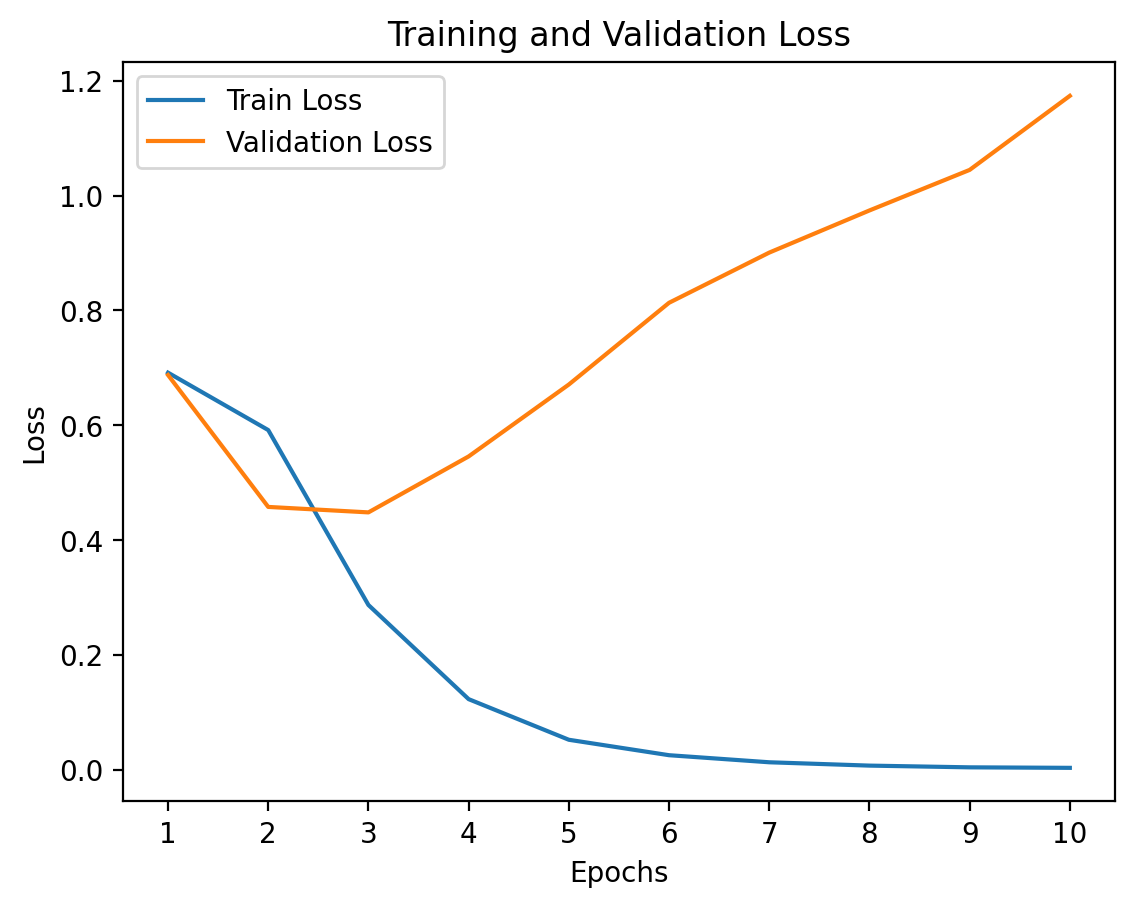

In [11]:
import torch.optim as optim

simple_model = SentimentClassifier(input_size=10000)
simple_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-4)

num_epochs = 10

epochs = list(range(1, num_epochs + 1))
train_loss_history_simple, val_loss_history_simple , val_acc_history_simple ,  time_taken_simple = train(
    simple_model,
    'models/model',
    optimizer,
    criterion,
    train_loader_bow,
    val_loader_bow,
    num_epochs,
    device
)

# Plot the training and validation loss history
plt.plot(epochs, train_loss_history_simple, label='Train Loss')
plt.plot(epochs, val_loss_history_simple, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



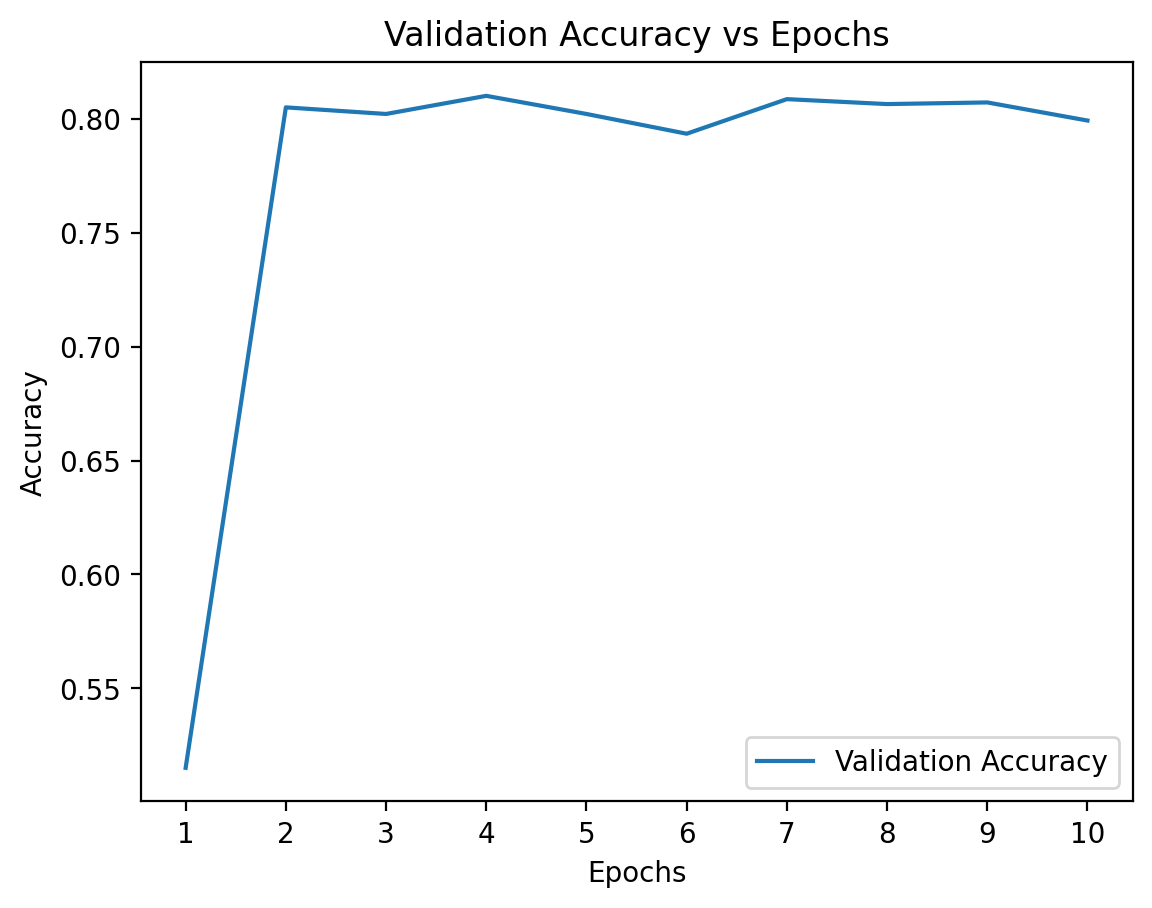

In [12]:
plt.plot(epochs, val_acc_history_simple, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.title('Validation Accuracy vs Epochs')
plt.show()

In [13]:
# print size of the model
import os

def get_model_size(model_path):
    size_bytes = os.path.getsize(model_path)
    size_mb = size_bytes / (1024 * 1024)
    return size_mb

model_size_mb = get_model_size('models/model.pt')
print(f'Model size: {model_size_mb:.2f} MB')

Model size: 20.19 MB


Inference time: 0.86 seconds
During inference Model size: 20.19 MB
Test Loss: 1.1674
Accuracy: 0.7875


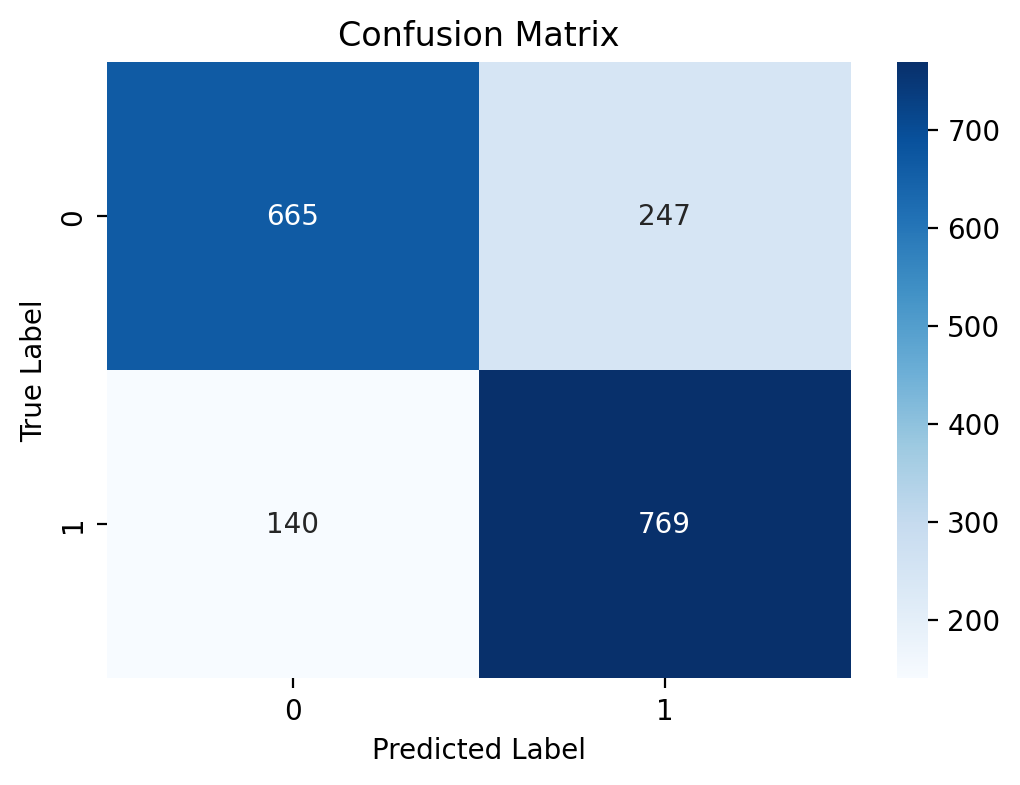

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# add inference time

def test(model, criterion, test_loader, device,model_path,half):

    start_time = time.time()
    model.eval()
    test_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            if isinstance(model, torch.nn.quantized.dynamic.modules.Linear):
                X_batch = X_batch.cpu()
                y_batch = y_batch.cpu()
                model = model.cpu()
            else:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

            # Convert input to half precision if needed
            if half:
                X_batch_half = X_batch.clone().half()
                y_pred_logits = model(X_batch_half)
            else:
              y_pred_logits = model(X_batch)


            loss = criterion(y_pred_logits, y_batch)
            test_loss += loss.item()

            # Get predicted labels
            y_pred_labels = torch.argmax(y_pred_logits, dim=1)  # Predicted class indices

            # Collect true and predicted labels for metrics
            all_y_true.extend(y_batch.cpu().numpy())
            all_y_pred.extend(y_pred_labels.cpu().numpy())

    end_time = time.time()
    infertime = end_time - start_time
    print(f'Inference time: {infertime:.2f} seconds')

    # print model size
    with torch.no_grad():
      infersize = get_model_size(model_path)
      print(f'During inference Model size: {infersize:.2f} MB')

    # Average test loss over all batches
    test_loss /= len(test_loader)

    # Compute metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    conf_matrix = confusion_matrix(all_y_true, all_y_pred)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix , infertime , infersize

accuracy_bow_1, conf_matrix_bow_1 ,bow_infertime, bow_infersize = test(simple_model, criterion, test_loader_bow, device,'models/model.pt',half=False)

## Dynamic Quantization with INT8
Apply dynamic quantization using `torch.quantization.quantize_dynamic()`. Evaluate the quantized model.

Dynamic quantization in PyTorch is designed for layers with weights that can be quantized post-training, and for which activations can be quantized on-the-fly during inference — hence the term dynamic.

Model size: 5.06 MB
Inference time: 0.44 seconds
During inference Model size: 5.06 MB
Test Loss: 1.1662
Accuracy: 0.7875


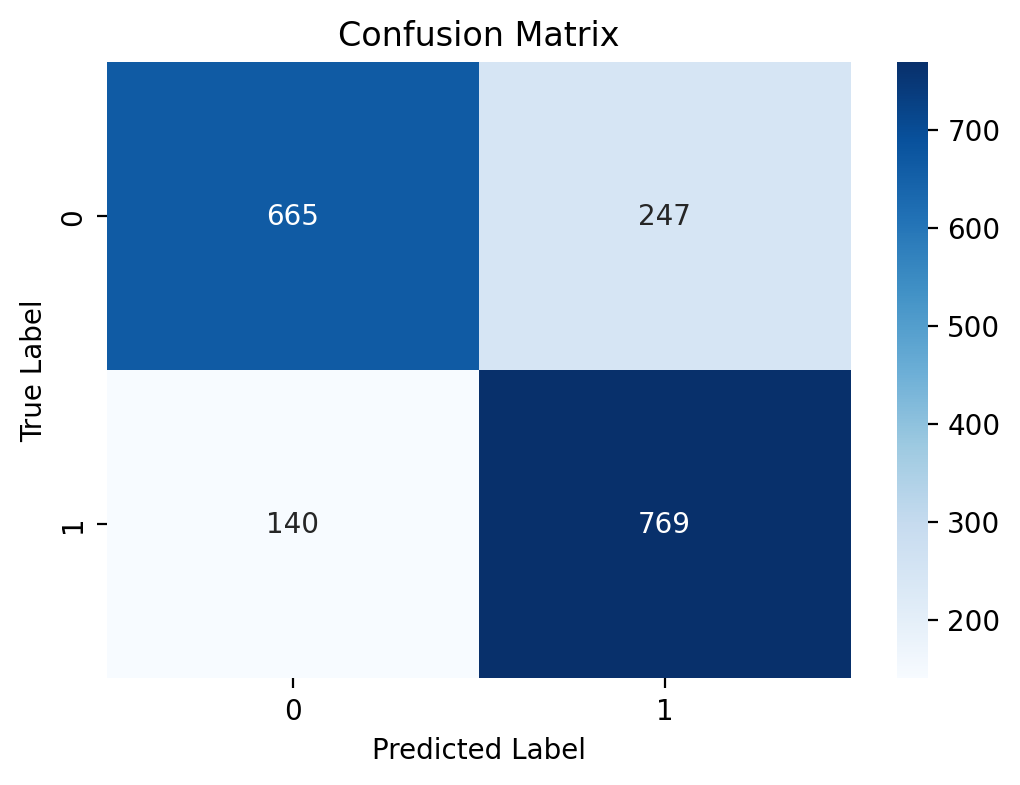

In [19]:
# Apply dynamic quantization
import torch
import torch.nn as nn
import torch.optim as optim

quantized_model = torch.quantization.quantize_dynamic(
    simple_model, {nn.Linear}, dtype=torch.qint8
)
torch.save(quantized_model.state_dict(), 'models/quantized_model.pt')

quantized_model.eval()
quantized_model.to('cpu')

model_size = get_model_size('models/quantized_model.pt')
print(f'Model size: {model_size:.2f} MB')

# device = torch.device('cpu')

accuracy_quant_1, conf_matrix_quant_1,quant_infertime, quant_infersize = test(quantized_model, criterion, test_loader_bow, device,'models/quantized_model.pt',half=False)

## Half Precision Quantization
Apply half-precision quantization using the `.half()` function. Evaluate the model.

Model size: 10.10 MB
Inference time: 0.75 seconds
During inference Model size: 10.10 MB
Test Loss: 1.1672
Accuracy: 0.7875


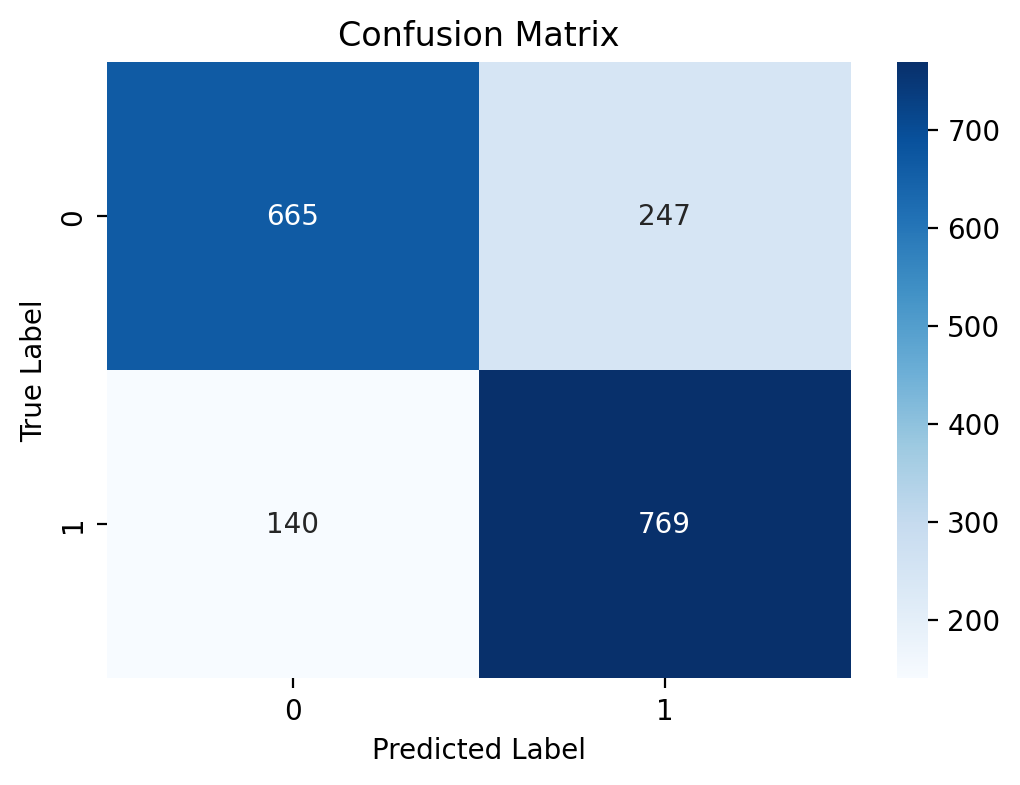

In [20]:
import copy

# Apply half-precision quantization
model_half = copy.deepcopy(simple_model).half()
torch.save(model_half.state_dict() , 'models/model_half.pt')
model_half_size = get_model_size('models/model_half.pt')
print(f'Model size: {model_half_size:.2f} MB')

# convert test loader bow to half
accuracy_half_1, conf_matrix_half_1,half_infertime, half_infersize = test(model_half, criterion, test_loader_bow, device,'models/model_half.pt',half = True)

## Comparison Table for Quantization Techniques
Fill a table comparing the original, dynamically quantized, and half-precision models in terms of accuracy, storage size, and inference time.

In [21]:
import pandas as pd

model_simple_size = get_model_size('models/model.pt')
model_quant_size = get_model_size('models/quantized_model.pt')
model_half_size = get_model_size('models/model_half.pt')

columns = [
    'Model',
    'Accuracy',
    'Inference Time (s)',
    'Model Size (MB)'
]

results_df = pd.DataFrame([
    ['Full Precision', accuracy_bow_1, bow_infertime, model_simple_size],
    ['Half Precision', accuracy_half_1, half_infertime, model_half_size],
    ['Quantized', accuracy_quant_1, quant_infertime, model_quant_size]
], columns=columns)

results_df


,Model,Accuracy,Inference Time (s),Model Size (MB)
0,Full Precision,0.787479,0.857009,20.194607
1,Half Precision,0.787479,0.745521,10.099398
2,Quantized,0.787479,0.443451,5.057398
